<a href="https://colab.research.google.com/github/nidanafila/Coursera2_TensorFlowDeveloper/blob/main/convert_model_to_tflite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train Your Own Model and Convert It to TFLite

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_lite/tflite_c03_exercise_convert_model_to_tflite.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_lite/tflite_c03_exercise_convert_model_to_tflite.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

This notebook uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing we'll use here.

This uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and load the Fashion MNIST data directly from TensorFlow:

# Setup

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pathlib

print(tf.__version__)

2.14.0


# Download Fashion MNIST Dataset


In [3]:
# Load the dataset
splits, info = tfds.load('fashion_mnist', with_info=True, as_supervised=True, split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'])

# Assign the splits
(train_examples, validation_examples, test_examples) = splits

# Get information about the dataset
num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
class_names = ['T-shirt_top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [5]:
with open('labels.txt', 'w') as f:
  f.write('\n'.join(class_names))

In [6]:
IMG_SIZE = 28

# Preprocessing data

## Preprocess

In [7]:
# Write a function to normalize and resize the images
def format_example(image, label):
    # Cast image to float32
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)

    # Resize the image if necessary
    image = tf.image.resize(image, (YOUR_TARGET_HEIGHT, YOUR_TARGET_WIDTH))

    # Normalize the image in the range [0, 1]
    image = image / 255.0

    return image, label


In [8]:
# Set the batch size to 32

BATCH_SIZE = 32

## Create a Dataset from images and labels

In [9]:
# Set the batch size
batch_size = 32

# Define your target height and width
YOUR_TARGET_HEIGHT = 224  # Replace with your desired height
YOUR_TARGET_WIDTH = 224   # Replace with your desired width

# Shuffle and batch the training set
train_batches = train_examples.shuffle(num_examples // 4).map(format_example).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Batch the validation set
validation_batches = validation_examples.map(format_example).batch(batch_size)

# Batch the test set
test_batches = test_examples.map(format_example).batch(batch_size)


# Building the model

In [10]:
"""
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
=================================================================
conv2d (Conv2D)              (None, 26, 26, 16)        160
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640
_________________________________________________________________
flatten (Flatten)            (None, 3872)              0
_________________________________________________________________
dense (Dense)                (None, 64)                247872
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650
=================================================================
Total params: 253,322
Trainable params: 253,322
Non-trainable params: 0
"""

'\nModel: "sequential"\n_________________________________________________________________\nLayer (type)                 Output Shape              Param #\n=================================================================\nconv2d (Conv2D)              (None, 26, 26, 16)        160\n_________________________________________________________________\nmax_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0\n_________________________________________________________________\nconv2d_1 (Conv2D)            (None, 11, 11, 32)        4640\n_________________________________________________________________\nflatten (Flatten)            (None, 3872)              0\n_________________________________________________________________\ndense (Dense)                (None, 64)                247872\n_________________________________________________________________\ndense_1 (Dense)              (None, 10)                650\n=================================================================\nTotal params: 25

In [11]:
model = tf.keras.Sequential([
    # Set the input shape to (28, 28, 1), kernel size=3, filters=16 and use ReLU activation
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(),
    # Set the number of filters to 32, kernel size to 3 and use ReLU activation
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    # Flatten the output layer to 1 dimension
    tf.keras.layers.Flatten(),
    # Add a fully connected layer with 64 hidden units and ReLU activation
    tf.keras.layers.Dense(64, activation='relu'),
    # Attach a final softmax classification head
    tf.keras.layers.Dense(10, activation='softmax')])

# Set the loss and accuracy metrics
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use 'categorical_crossentropy' if your labels are one-hot encoded
    metrics=['accuracy'])


## Train

In [18]:
# Assuming YOUR_TARGET_HEIGHT and YOUR_TARGET_WIDTH are the dimensions of your resized images
YOUR_TARGET_HEIGHT = 224
YOUR_TARGET_WIDTH = 224

epochs = 10

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(YOUR_TARGET_HEIGHT, YOUR_TARGET_WIDTH, 1)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

# Train the model
history = model.fit(train_batches, epochs=epochs, validation_data=validation_batches)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_batches)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")




Epoch 1/10
1500/1500 [==============================] - 48s 31ms/step - loss: 0.6103 - accuracy: 0.7836 - val_loss: 0.4674 - val_accuracy: 0.8362
Epoch 2/10
1500/1500 [==============================] - 44s 29ms/step - loss: 0.4376 - accuracy: 0.8425 - val_loss: 0.3879 - val_accuracy: 0.8592
Epoch 3/10
1500/1500 [==============================] - 42s 28ms/step - loss: 0.3878 - accuracy: 0.8594 - val_loss: 0.3462 - val_accuracy: 0.8765
Epoch 4/10
1500/1500 [==============================] - 43s 28ms/step - loss: 0.3609 - accuracy: 0.8683 - val_loss: 0.3797 - val_accuracy: 0.8540
Epoch 5/10
1500/1500 [==============================] - 43s 28ms/step - loss: 0.3347 - accuracy: 0.8767 - val_loss: 0.3297 - val_accuracy: 0.8785
Epoch 6/10
1500/1500 [==============================] - 42s 28ms/step - loss: 0.3195 - accuracy: 0.8825 - val_loss: 0.3169 - val_accuracy: 0.8843
Epoch 7/10
1500/1500 [==============================] - 44s 29ms/step - loss: 0.3057 - accuracy: 0.8877 - val_loss: 0.3028 -

# Exporting to TFLite

In [20]:
# EXERCISE: Use the tf.saved_model API to save your model in the SavedModel format.
export_dir = 'saved_model/1'

tf.saved_model.save(model, export_dir)

In [21]:
# Select mode of optimization
mode = "Speed"

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [22]:
# EXERCISE: Use the TFLiteConverter SavedModel API to initialize the converter

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [23]:
tflite_model_file = 'model.tflite'

with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)

# Test if your model is working

In [24]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

1/1 [==============================] - 0s 258ms/step


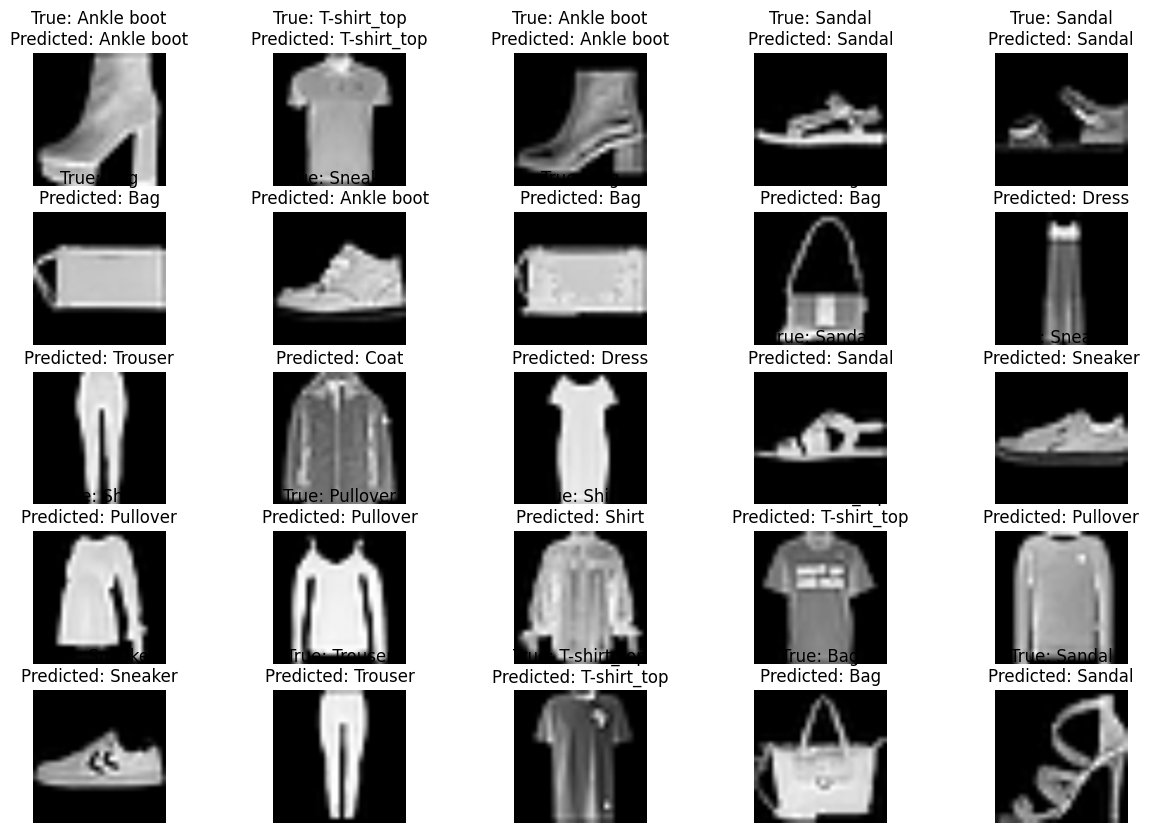

In [25]:
import numpy as np

# Function to display images with their predicted class and confidence
def plot_images(images, labels, predictions, class_names):
    plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"True: {class_names[labels[i]]}\nPredicted: {class_names[np.argmax(predictions[i])]}")
        plt.axis('off')
    plt.show()

# Randomly sample some test images
num_images_to_sample = 25
random_test_images = []
random_test_labels = []

for batch in test_batches.take(1):
    images, labels = batch
    random_indices = np.random.choice(len(labels), num_images_to_sample, replace=False)
    random_test_images = images.numpy()[random_indices]
    random_test_labels = labels.numpy()[random_indices]

# Make predictions on the sampled images
predictions = model.predict(random_test_images)

# Display the results
plot_images(random_test_images, random_test_labels, predictions, class_names)


In [26]:
#@title Utility functions for plotting
# Utilities for plotting

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  img = np.squeeze(img)

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label.numpy():
    color = 'green'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks(list(range(10)), class_names, rotation='vertical')
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array[0], color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array[0])

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('green')

1/1 [==============================] - 0s 68ms/step


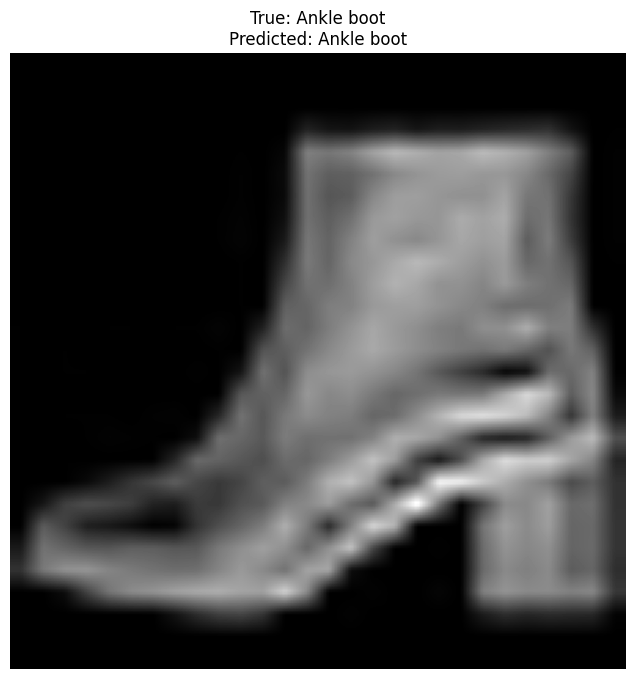

In [27]:
# Select the index of the image to display
index_to_display = 10  # Change this to the desired index

# Get a batch of images and labels
for images, labels in tfds.as_numpy(test_batches.take(1)):
    selected_image = images[index_to_display]
    selected_label = labels[index_to_display]
    selected_image_batch = tf.expand_dims(selected_image, axis=0)
    selected_image_prediction = model.predict(selected_image_batch)

# Display the selected image along with its true label and predicted label
plt.figure(figsize=(8, 8))
plt.imshow(selected_image.squeeze(), cmap='gray')  # Squeeze removes the single-dimensional entries
plt.title(f"True: {class_names[selected_label]}\nPredicted: {class_names[np.argmax(selected_image_prediction)]}")
plt.axis('off')
plt.show()


# Download TFLite model and assets

**NOTE: You might have to run to the cell below twice**

In [28]:
try:
  from google.colab import files
  files.download(tflite_model_file)
  files.download('labels.txt')
except:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Deploying TFLite model

Now once you've the trained TFLite model downloaded, you can ahead and deploy this on an Android/iOS application by placing the model assets in the appropriate location.

# Prepare the test images for download (Optional)

In [29]:
!mkdir -p test_images

In [38]:
# Prepare the Test Images for Download

import os
from PIL import Image

# Create a directory to save the test images
os.makedirs("test_images", exist_ok=True)

# Save the randomly sampled test images
for i, (image, label) in enumerate(tfds.as_numpy(test_batches.take(num_images_to_sample))):
    # Convert to uint8 format for image saving
    image = (image.squeeze() * 255).astype(np.uint8)

    # Ensure the image is properly squeezed
    image = np.squeeze(image)

    # Reshape the image to 2D
    if image.ndim == 3:
        image = image[:, :, 0]  # Take only one channel if there are multiple channels

    # Save the image
    image_filename = f"test_images/test_image_{i + 1}_label_{label}.png"
    Image.fromarray(image, mode='L').save(image_filename)  # 'L' mode for grayscale images

print("Test images saved successfully.")


Test images saved successfully.


In [39]:
!ls test_images

'test_image_10_label_[7 0 0 3 6 7 5 4 7 7 3 7 3 3 9 5 5 5 3 5 3 2 1 7 7 6 0 3 8 2 4 3].png'
'test_image_11_label_[3 2 6 5 0 9 6 9 5 7 9 3 0 1 8 6 6 3 7 0 2 3 5 3 8 3 7 7 6 9 0 3].png'
'test_image_12_label_[5 3 5 4 3 8 2 5 9 1 2 4 9 3 7 4 1 1 9 3 3 0 4 9 6 9 3 2 8 4 5 0].png'
'test_image_13_label_[4 1 5 3 8 7 5 8 4 7 8 1 1 5 5 2 3 5 0 1 8 1 4 7 3 2 6 6 7 9 0 3].png'
'test_image_14_label_[5 9 7 8 3 6 3 7 2 8 6 2 4 6 6 4 2 6 7 1 0 8 0 0 6 5 5 8 0 9 8 0].png'
'test_image_15_label_[7 0 1 7 4 6 8 6 1 2 5 7 5 9 0 2 6 6 5 1 8 7 8 1 1 6 5 4 0 7 1 6].png'
'test_image_16_label_[1 0 0 0 3 4 5 4 1 1 8 0 5 8 7 9 3 0 4 5 7 3 7 8 7 1 0 6 5 1 5 1].png'
'test_image_17_label_[2 5 8 0 4 1 9 2 0 1 6 1 8 7 6 7 2 4 5 8 5 2 7 5 2 8 1 6 9 9 8 3].png'
'test_image_18_label_[6 3 7 2 8 0 3 4 6 4 6 7 7 0 4 1 4 8 0 1 5 4 9 9 1 4 4 8 5 5 4 4].png'
'test_image_19_label_[2 0 3 4 4 6 7 6 2 8 3 7 8 0 9 7 1 1 8 6 0 4 3 2 0 3 0 8 9 0 1 7].png'
'test_image_1_label_[5 0 5 8 9 6 3 8 0 2 9 4 3 7 5 0 8 8 0 5 1 0 1 8 7 7 7 6 2 3

In [40]:
!zip -qq fmnist_test_images.zip -r test_images/

In [41]:
try:
  files.download('fmnist_test_images.zip')
except:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>